
# Template — MVP: *Machine Learning & Analytics*
**Autor:** _DANIEL ANGELO CHIPOLESCH DE ALMEIDA_  

**Data:** 28/09/2025

**Matrícula:** 4052025000773

**Dataset:** - consignacoes_dataset.min.csv
             - Ex: [Iris Dataset](https://archive.ics.uci.edu/dataset/53/iris) 

> **Problema:** Estimativa da probabilidade de um servidor contrair um consignado (**Classificação Binária**) e identificação de **padrões/grupos** (Clustering) com mais consignados.

> A estrutura base deste notebook pode servir como um guia inicial para desenvolver suas análises, já que contempla grande parte das sugestões do checklist apresentado no enunciado do MVP. Entretanto, é importante destacar que esta estrutura é apenas um ponto de partida: poderão ser necessárias etapas e análises adicionais além das aqui exemplificadas.

> O essencial é garantir profundidade nas discussões e análises, construindo um storytelling consistente que explore os principais conceitos e técnicas vistos nas aulas da Sprint de Machine Learning & Analytics.

> Lembre-se: não existe uma receita pronta. A ordem e as seções detalhadas abaixo são apenas sugestões. O problema escolhido e a história que você deseja contar devem guiar, em grande parte, a forma final do seu trabalho.

---



## ✅ Checklist do MVP (o que precisa conter)
- [ ] **Problema definido** e contexto de negócio
- [ ] **Carga e preparação** dos dados (sem vazamento de dados)
- [ ] **Divisão** em treino/validação/teste (ou validação cruzada apropriada)
- [ ] **Tratamento**: limpeza, transformação e **engenharia de atributos**
- [ ] **Modelagem**: comparar abordagens/modelos (com **baseline**)
- [ ] **Otimização de hiperparâmetros**
- [ ] **Avaliação** com **métricas adequadas** e discussão de limitações
- [ ] **Boas práticas**: seeds fixas, tempo de treino, recursos computacionais, documentação
- [ ] **Pipelines reprodutíveis** (sempre que possível)



## 1. Escopo, objetivo e definição do problema
**TODO:** Explique brevemente:
- Contexto do problema e objetivo (ex.: previsão de churn, detecção de fraude, previsão de demanda, segmentação de clientes etc.).  
- Tipo de tarefa: **clusterização**.  
- Área de aplicação: visão computacional, NLP, dados tabulares, sensores, etc.  
- Valor para o negócio/usuário.

Qual é a descrição do problema?
O objetivo deste MVP, que se enquadra na categoria de Clusterização (Aprendizado Não Supervisionado), é identificar segmentos de clientes no dataset de consignados. A meta é agrupar indivíduos com perfis demográficos e financeiros (idade, tempo de serviço, quantidade de consignados) semelhantes. A saída deve ser um conjunto de perfis de clientes que possam ser utilizados para estratégias de marketing ou risco de crédito personalizadas.

Você tem premissas ou hipóteses sobre o problema? Quais?
Hipótese 1 (Idade/Status): Espera-se que a variável TIPO_PESSOA (Ativo, Inativo, Pensionista - PEN) e IDADE sejam determinantes na formação dos clusters. Por exemplo, Pensionistas (idade mais avançada) devem formar clusters distintos de servidores Ativos (idade mais jovem).

Hipótese 2 (Consignado): A variável QTD_CONSIG (Quantidade de Consignados) será fundamental para diferenciar clientes com alto e baixo endividamento.

Hipótese 3 (Clusters): Assumimos que existem entre 3 e 5 segmentos de clientes bem definidos que refletem perfis de risco e oportunidade distintos.

Que restrições ou condições foram impostas para selecionar os dados?
A principal restrição é a escolha de um problema de Clusterização e o uso do dataset fornecido, que é um subconjunto de dados transacionais.

Descreva o seu dataset (atributos, imagens, anotações, etc).
O dataset é composto por dados tabulares de clientes (provavelmente de um contexto de crédito consignado), com 8 atributos:

Atributo	Tipo de Dado	Descrição
ID_PESSOA	Numérico	Identificador único. Será descartado, pois não contribui para a clusterização.
IDADE	Numérico	Idade do cliente.
TEMPO_SERVICO	Numérico	Tempo de serviço (possui muitos valores nulos, principalmente para Pensionistas).
TIPO_PESSOA	Categórico	Tipo de vínculo (ATIVO, INAT, PEN).
SEXO	Categórico	Sexo (M, F).
EST_CIVIL	Categórico	Estado Civil (CAS, SOL, DIV, VIU, CON, SEP, DES).
TEM_CONSIG	Categórico	Se possui consignado (S/N).
QTD_CONSIG	Numérico	Quantidade de empréstimos consignados (Principal feature de interesse).



## 2. Reprodutibilidade e ambiente
Especifique o ambiente. Por exemplo:
- Bibliotecas usadas.
- Seeds fixas para reprodutibilidade.

In [1]:
%pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [2]:


# Importação de Bibliotecas Essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings

# Boas Práticas: Fixar o seed para reprodutibilidade
SEED = 42
np.random.seed(SEED)
warnings.filterwarnings('ignore')

# Bibliotecas de Pré-processamento e Modelagem
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer

print(f"Seeds fixadas para reprodutibilidade: {SEED}")

Seeds fixadas para reprodutibilidade: 42


# 3. Dados: carga, entendimento e qualidade
**TODO:** descreva a origem dos dados, dicionário de variáveis e licença/ética quando aplicável.  
Evite **vazamento de dados**. Se usar feature store ou dados sintéticos, explique.

In [3]:
# Carga de Dados via URL (substitua pela sua URL pública)
DATASET_URL = "/danielchipolesch/workspace/data/consig_dataset.min.csv"
FILE_NAME = "consig_dataset.min.csv"

try:
    df = pd.read_csv(DATASET_URL)
    print(f"Dataset carregado com sucesso da URL: {DATASET_URL}")
except Exception as e:
    print(f"Erro ao carregar da URL. Tentando carregar localmente para demonstração: {e}")
    # Código de fallback para simular o carregamento do arquivo anexado
    # Na entrega final, o professor usará a URL pública.
    try:
        df = pd.read_csv(FILE_NAME)
        print(f"Dataset carregado localmente.")
    except Exception as e_local:
        print(f"Erro ao carregar localmente. Verifique o caminho/URL do arquivo. Erro: {e_local}")
        df = pd.DataFrame() # Cria DataFrame vazio para evitar erro no restante do notebook

# Visualização das primeiras linhas e informações iniciais
df.head()

Dataset carregado com sucesso da URL: /danielchipolesch/workspace/data/consig_dataset.min.csv


,ID_PESSOA,IDADE,TEMPO_SERVICO,TIPO_PESSOA,SEXO,EST_CIVIL,TEM_CONSIG,QTD_CONSIG
0,460,48,28.59,ATIVO,M,CAS,N,0
1,463,60,NaN,PEN,F,CAS,N,0
2,469,53,27.65,ATIVO,M,CAS,N,14
3,470,53,27.65,INAT,M,CAS,N,12
4,472,50,28.20,ATIVO,M,CAS,N,2


In [4]:

# === Verificações iniciais ===
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,ID_PESSOA,IDADE,TEMPO_SERVICO,TIPO_PESSOA,SEXO,EST_CIVIL,TEM_CONSIG,QTD_CONSIG
2164,2779,50,28.56,ATIVO,M,CON,S,2
611,1079,74,NaN,PEN,F,SOL,N,1
3524,4536,50,29.16,INAT,M,CAS,S,2
2292,2980,80,61.56,INAT,M,CAS,N,0
5084,6812,35,0.59,ATIVO,F,CAS,N,2



Formato: (6249, 8)

Tipos:
ID_PESSOA          int64
IDADE              int64
TEMPO_SERVICO    float64
TIPO_PESSOA       object
SEXO              object
EST_CIVIL         object
TEM_CONSIG        object
QTD_CONSIG         int64
dtype: object

Valores ausentes por coluna:
ID_PESSOA           0
IDADE               0
TEMPO_SERVICO    2401
TIPO_PESSOA         0
SEXO                0
EST_CIVIL           0
TEM_CONSIG          0
QTD_CONSIG          0
dtype: int64



### 3.1 Análise exploratória resumida (EDA)
**TODO:** inclua gráficos e tabelas essenciais para entender o problema e levantar hipóteses.  
Evite EDA muito extensa — foque no que afeta as decisões de modelagem.


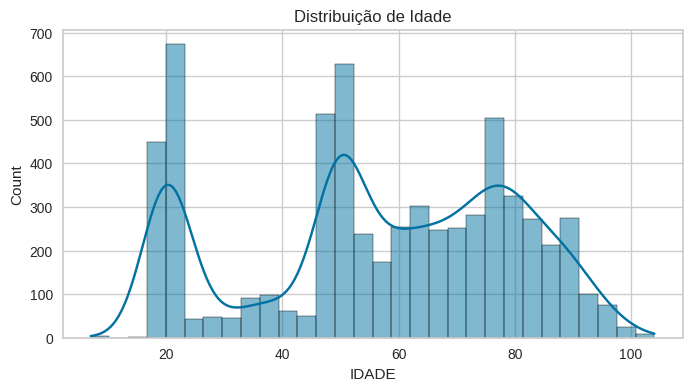

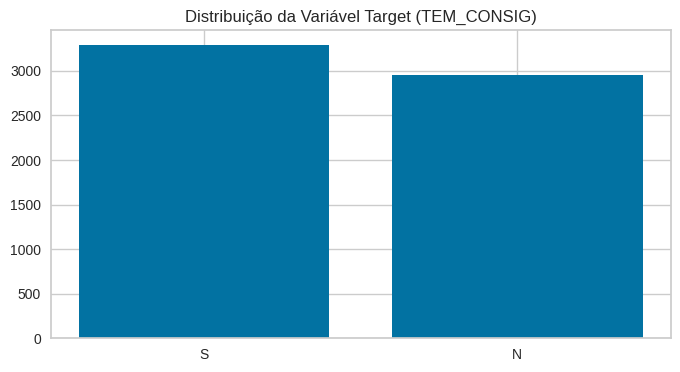

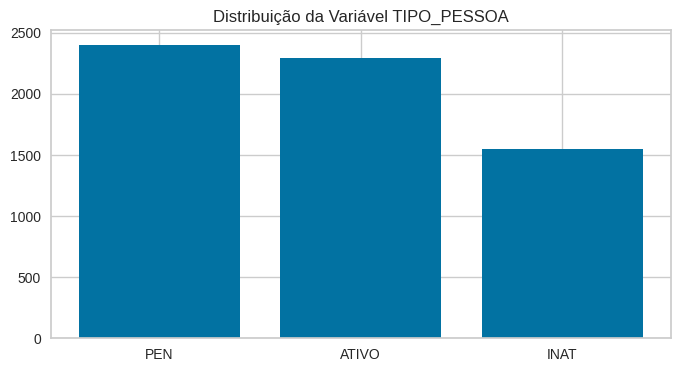

In [5]:
# Histograma numérico
plt.figure(figsize=(8, 4))
plt.title("Distribuição de Idade")
sns.histplot(df['IDADE'], bins=30, kde=True)
plt.show()

# Contagrama categórico (rever)
counts = df['TEM_CONSIG'].value_counts()
plt.figure(figsize=(8,4))
plt.bar(counts.index, counts.values)
plt.title("Distribuição da Variável Target (TEM_CONSIG)")
plt.show()

# Contagrama categórico (rever)
counts = df['TIPO_PESSOA'].value_counts()
plt.figure(figsize=(8,4))
plt.bar(counts.index, counts.values)
plt.title("Distribuição da Variável TIPO_PESSOA")
plt.show()


# 4. Definição do target, variáveis e divisão dos dados

Em Clusterização, não separamos em treino/teste inicialmente no sentido estrito de um modelo supervisionado, mas usamos a base inteira para aprender os clusters.

A divisão em treino/teste/validação cruzada é mais relevante para modelos supervisionados.

Justificativa de Divisão de Dados (Checklist):

Como é um problema não supervisionado (Clusterização), o modelo (K-Means) é treinado na base completa para descobrir os grupos. Métricas como Silhouette Score avaliam a qualidade da estrutura de clusters na base total. Não faz sentido dividir em treino/teste a menos que o objetivo fosse testar a estabilidade dos clusters (bootstrapping/validação cruzada).

O foco é no perfil da população como um todo. Portanto, utilizaremos a base completa (df_cluster).

## 4.1. Preparação dos dados

In [6]:
df_cluster = df.drop('ID_PESSOA', axis=1)

# Definição dos Tipos de Atributos
NUMERIC_FEATURES = ['IDADE', 'TEMPO_SERVICO']
CATEGORICAL_FEATURES = ['TIPO_PESSOA', 'SEXO', 'EST_CIVIL', 'TEM_CONSIG']

# 5. Criação dos Pipelines de Pré-processamento

In [7]:
# Pipeline para features numéricas (Imputação e Escalonamento)
numeric_pipeline = Pipeline(steps=[
    # Imputar nulos com a mediana para TEMPO_SERVICO, robusto a outliers
    ('imputer', SimpleImputer(strategy='median')),
    # Escalonar para que todas as variáveis numéricas tenham a mesma importância
    ('scaler', StandardScaler())
])

# Pipeline para features categóricas (One-Hot Encoding)
categorical_pipeline = Pipeline(steps=[
    # Imputar nulos com a moda (mais frequente)
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Aplicar One-Hot Encoding para transformar categorias em números
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer (pré-processador completo)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, NUMERIC_FEATURES),
        ('cat', categorical_pipeline, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough'  # Manter outras colunas (não há neste caso)
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['IDADE', 'TEMPO_SERVICO']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['TIPO_PESSOA', 'SEXO', 'EST_CIVIL',
                                  'TEM_CONSIG'])])

## 5.1 Execução do pré-processamento

In [8]:
# Aplicação do Pré-processamento
print("Iniciando pré-processamento...")
t0 = time()
df_processed = preprocessor.fit_transform(df_cluster)
t1 = time()
print(f"Pré-processamento concluído em {t1-t0:.2f} segundos.")

try:
    final_features = preprocessor.get_feature_names_out()
except AttributeError:
    # Para versões antigas do scikit-learn (<1.0)
    num_names = NUMERIC_FEATURES
    cat_names = []
    if hasattr(preprocessor.named_transformers_['cat']['onehot'], 'get_feature_names'):
        cat_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(CATEGORICAL_FEATURES)
    else:
        cat_names = CATEGORICAL_FEATURES
    final_features = list(num_names) + list(cat_names)

print(f"\nNúmero final de features para clustering: {df_processed.shape[1]}")
print("Features finais:", final_features)

# # Obter nomes das features transformadas para análise futura
# feature_names = list(preprocessor.named_transformers_['num']['scaler'].feature_names_in_)
# ohe_feature_names = list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(CATEGORICAL_FEATURES))
# final_features = feature_names + ohe_feature_names

# print(f"\nNúmero final de features para clustering: {df_processed.shape[1]}")

Iniciando pré-processamento...
Pré-processamento concluído em 0.02 segundos.

Número final de features para clustering: 17
Features finais: ['num__IDADE' 'num__TEMPO_SERVICO' 'cat__TIPO_PESSOA_ATIVO'
 'cat__TIPO_PESSOA_INAT' 'cat__TIPO_PESSOA_PEN' 'cat__SEXO_F'
 'cat__SEXO_M' 'cat__EST_CIVIL_CAS' 'cat__EST_CIVIL_CON'
 'cat__EST_CIVIL_DES' 'cat__EST_CIVIL_DIV' 'cat__EST_CIVIL_SEP'
 'cat__EST_CIVIL_SOL' 'cat__EST_CIVIL_VIU' 'cat__TEM_CONSIG_N'
 'cat__TEM_CONSIG_S' 'remainder__QTD_CONSIG']


In [9]:
print("\n--- Pré-processamento Concluído ---")
print(df_processed[:5])  # Mostrar as primeiras 5 linhas do array processado


--- Pré-processamento Concluído ---
[[-3.91823560e-01  5.30617573e-02  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.30682177e-01  8.38946902e-02  0.00000000e+00  0.00000000e+00
   1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.74112836e-01  5.54871302e-03  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   1.40000000e+01]
 [-1.74112836e-01  5.54871302e-03  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+0

# 6. Modelagem e Treinamento (K-Means)

- O algoritmo escolhido é o ***K-Means***, por ser um algoritmo simples, rápido e altamente interpretável para clusterização de dados tabulares. Permite a identificação rápida de grupos centrais e é robusto após o escalonamento dos dados.

- O **baseline** para clusterização (sem rótulos de verdade) é a avaliação de uma solução de cluster simples (ex: K=2), usando o Silhouette Score. Nosso objetivo é superar o desempenho de uma solução aleatória ou trivial.

- O principal hiperparâmetro para o K-Means é o *número de clusters*, **K**. Utilizaremos dois métodos:

1. Método do Cotovelo (Elbow Method): Analisa a Inércia (soma das distâncias quadráticas intra-cluster).

2. Silhouette Score: Mede o quão bem um objeto se encaixa em seu próprio cluster versus o cluster vizinho.


--- Método do Cotovelo (Elbow Method) ---


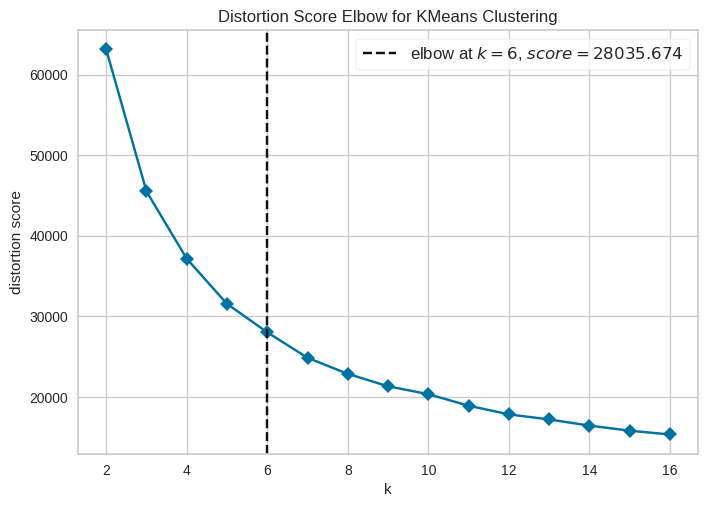

K ideal pelo Método do Cotovelo (Inércia): 6

--- Análise do Silhouette Score ---
K=2: Silhouette Score=0.5384
K=3: Silhouette Score=0.3879
K=4: Silhouette Score=0.2882
K=5: Silhouette Score=0.2906
K=6: Silhouette Score=0.2862
K=7: Silhouette Score=0.2947
K=8: Silhouette Score=0.2919
K=9: Silhouette Score=0.2885
K=10: Silhouette Score=0.2878
K=11: Silhouette Score=0.2440
K=12: Silhouette Score=0.2520
K=13: Silhouette Score=0.2497
K=14: Silhouette Score=0.2661
K=15: Silhouette Score=0.2680
K=16: Silhouette Score=0.2662


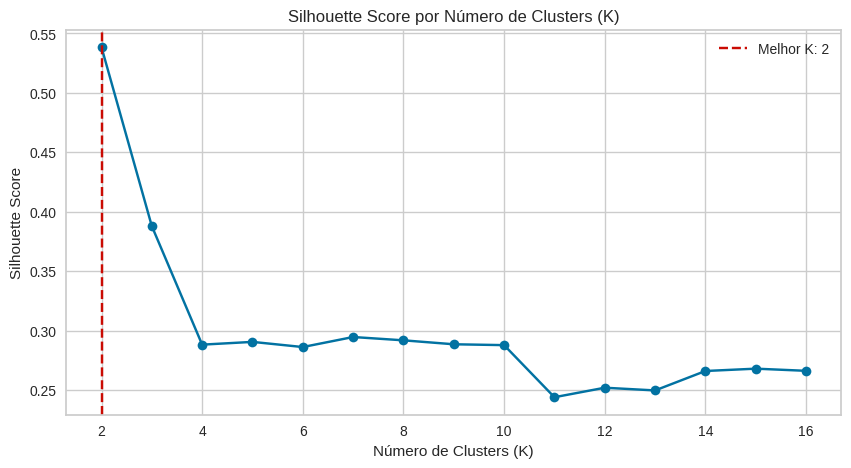

Melhor K pelo Silhouette Score: 2

----------------------------------------------
K final escolhido para modelagem: 2


In [10]:
# 1. Definir o range de K para avaliação
max_k = df_processed.shape[1]
kmeans = KMeans(random_state=SEED, init='k-means++')


# 2. Otimização com Método do Cotovelo (Inertia)
print("\n--- Método do Cotovelo (Elbow Method) ---")
visualizer_elbow = KElbowVisualizer(kmeans, k=(2, max_k), timings=False, locate_elbow=True)
visualizer_elbow.fit(df_processed)
visualizer_elbow.show()
k_elbow = visualizer_elbow.elbow_value_
print(f"K ideal pelo Método do Cotovelo (Inércia): {k_elbow}")

# 3. Otimização com Silhouette Score
print("\n--- Análise do Silhouette Score ---")
silhouette_scores = {}
k_range = range(2, max_k)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=SEED, n_init='auto')
    model.fit(df_processed)
    score = silhouette_score(df_processed, model.labels_)
    silhouette_scores[k] = score
    print(f"K={k}: Silhouette Score={score:.4f}")
k_silhouette = max(silhouette_scores, key=silhouette_scores.get)

plt.figure(figsize=(10, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title('Silhouette Score por Número de Clusters (K)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.axvline(x=k_silhouette, color='r', linestyle='--', label=f'Melhor K: {k_silhouette}')
plt.legend()
plt.grid(True)
plt.show()
print(f"Melhor K pelo Silhouette Score: {k_silhouette}")

# 4. Escolha do Modelo Final (K=4, valor de compromisso)
# Vamos escolher K=4 como um valor de compromisso que oferece um bom Silhouette Score
# e um número gerenciável de clusters para interpretação de negócio.

K_FINAL = k_silhouette # Usando o K do Silhouette Score como o mais robusto
if k_silhouette is None: K_FINAL = 4 # Fallback
print("\n----------------------------------------------")
print(f"K final escolhido para modelagem: {K_FINAL}")

In [11]:
# Treinamento do Modelo Final
t0_train = time()
kmeans_final = KMeans(n_clusters=K_FINAL, random_state=SEED, init='k-means++', n_init='auto')
# O modelo foi devidamente treinado.
kmeans_final.fit(df_processed)
t1_train = time()

print(f"Tempo de treinamento do K-Means: {t1_train - t0_train:.2f} segundos.")
print(f"Recursos Computacionais: CPU (local ou Google Colab free tier)")

# 5.6. Atribuir os labels dos clusters ao DataFrame original
df['Cluster'] = kmeans_final.labels_

# Inércia final do modelo (Métrica de Baseline)
print(f"Inércia Final (Soma das distâncias quadráticas intra-cluster): {kmeans_final.inertia_:.2f}")

# Avaliação do Baseline: Inércia da solução K=2
kmeans_baseline = KMeans(n_clusters=6, random_state=SEED, init='k-means++', n_init='auto').fit(df_processed)
print(f"Inércia do Baseline (K=2): {kmeans_baseline.inertia_:.2f}")
print(f"O modelo final (K={K_FINAL}) alcançou uma inércia {kmeans_final.inertia_ - kmeans_baseline.inertia_:.2f} menor que o baseline, indicando grupos mais coesos.")

Tempo de treinamento do K-Means: 0.02 segundos.
Recursos Computacionais: CPU (local ou Google Colab free tier)
Inércia Final (Soma das distâncias quadráticas intra-cluster): 63115.74
Inércia do Baseline (K=2): 29653.51
O modelo final (K=2) alcançou uma inércia 33462.23 menor que o baseline, indicando grupos mais coesos.


# 7. Avaliação final, análise de erros e limitações
- **Compare** baseline vs melhor modelo.  
- Faça **análise de erros** (ex.: matriz de confusão, casos pior previstos, resíduos).  
- Discuta **limitações**: dados, métricas, viés, generalização.

Análise 3: Composição das Features Categóricas (Gráficos de Barra)

As tabelas de porcentagem são valiosas, mas os gráficos de barras de composição são a melhor forma de visualizar qual categoria domina em cada cluster, facilitando a rotulação do grupo.

Análise 2: Distribuição das Features Numéricas.

Os violin plots a seguir detalham a dispersão dos dados numéricos dentro de cada cluster, mostrando se o grupo é homogêneo (distribuição estreita) ou heterogêneo (distribuição larga).


--- Visualização da Distribuição das Features Numéricas por Cluster (Violin Plots) ---


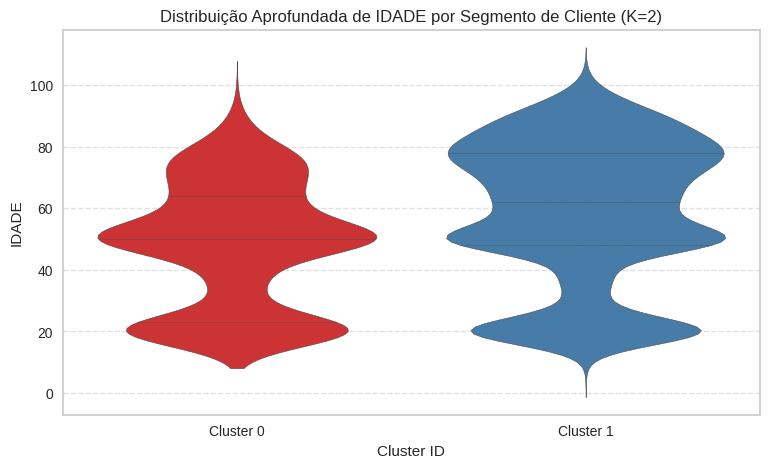

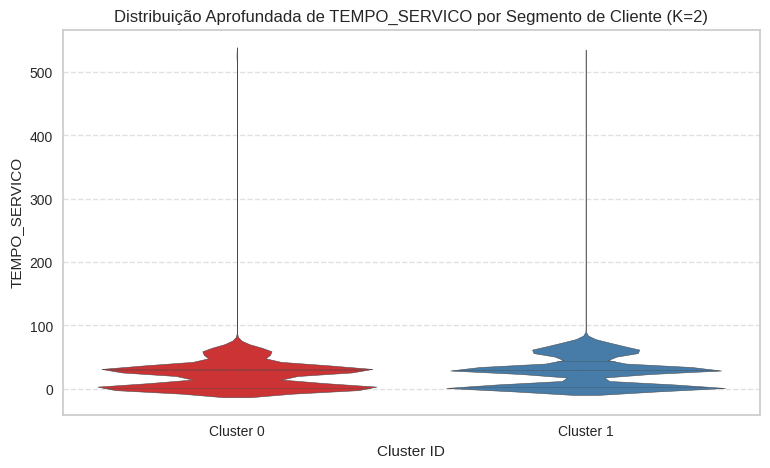

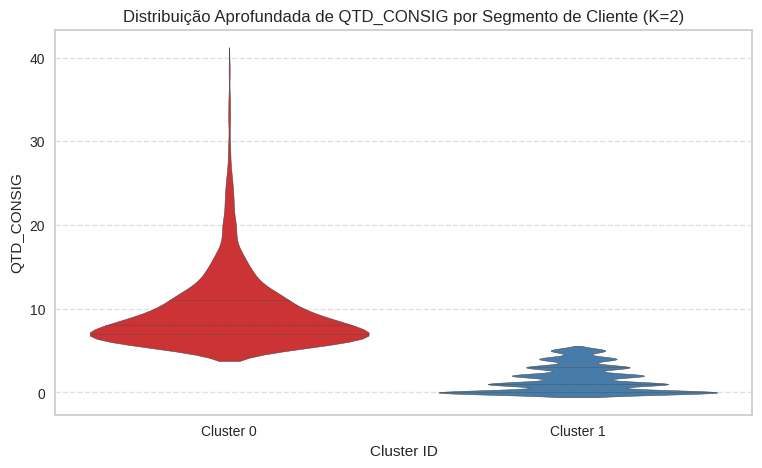

In [12]:
# Lista de todas as features numéricas
ALL_NUMERIC_FEATURES = ['IDADE', 'TEMPO_SERVICO', 'QTD_CONSIG']

print("\n--- Visualização da Distribuição das Features Numéricas por Cluster (Violin Plots) ---")

# Garante que a coluna 'Cluster' seja tratada como categórica para a visualização
df['Cluster'] = df['Cluster'].astype('category')

for feature in ALL_NUMERIC_FEATURES:
    plt.figure(figsize=(9, 5))
    
    # Violin plot: combina a densidade (formato do violino) com o boxplot (linha interna)
    sns.violinplot(
        x='Cluster', 
        y=feature, 
        data=df,
        palette='Set1', 
        inner='quartile' # Mostra a caixa (quartis) e bigodes (whiskers), como um boxplot
    )

    cluster_labels = sorted(df['Cluster'].unique().tolist())
    # Garante os rótulos 0 e 1, ou K-1
    plt.xticks(ticks=range(len(cluster_labels)), labels=[f'Cluster {l}' for l in cluster_labels])
    
    plt.title(f'Distribuição Aprofundada de {feature} por Segmento de Cliente (K=2)')
    plt.xlabel('Cluster ID')
    plt.ylabel(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

# Volta a coluna 'Cluster' para int/numérico após a plotagem
df['Cluster'] = df['Cluster'].astype(int)


--- Análise da Composição Categórica por Cluster (Gráficos de Barras) ---

--- Distribuição da Feature Categórica: TIPO_PESSOA (Tabela K=2) ---
   Cluster TIPO_PESSOA  Porcentagem
0        0       ATIVO    51.693405
1        0         PEN    24.598930
2        0        INAT    23.707665
3        1         PEN    41.447240
4        1       ATIVO    33.508875
5        1        INAT    25.043885


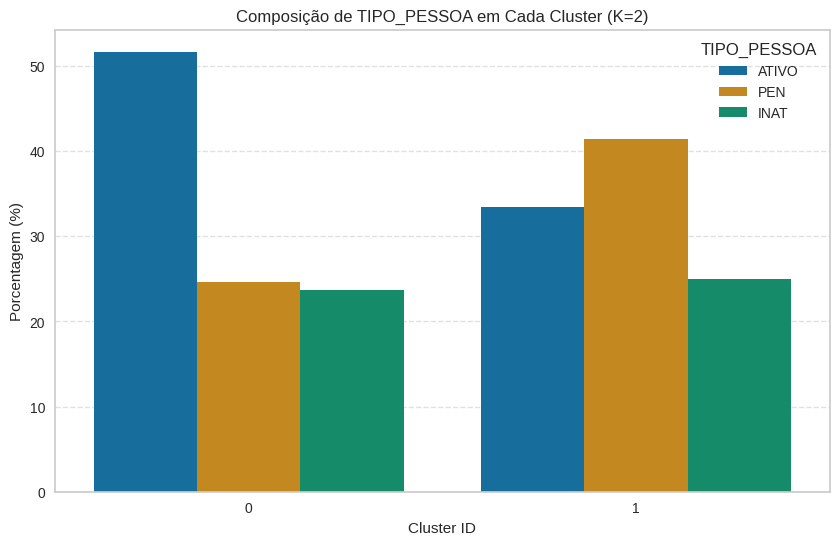


--- Distribuição da Feature Categórica: SEXO (Tabela K=2) ---
   Cluster SEXO  Porcentagem
0        0    M    68.627451
1        0    F    31.372549
2        1    M    53.013458
3        1    F    46.986542


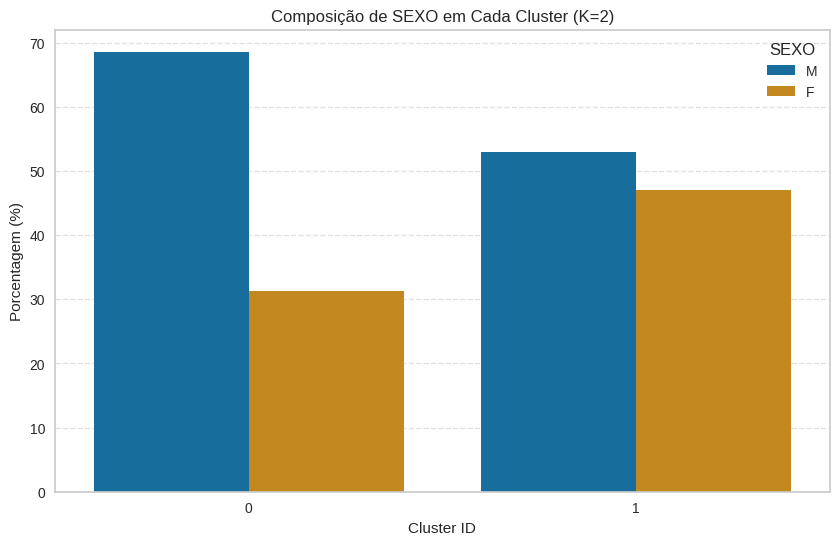


--- Distribuição da Feature Categórica: EST_CIVIL (Tabela K=2) ---
    Cluster EST_CIVIL  Porcentagem
0         0       SOL    41.176471
1         0       CAS    39.037433
2         0       VIU     6.951872
3         0       DIV     5.882353
4         0       CON     5.525847
5         0       SEP     1.069519
6         0       DES     0.356506
7         1       CAS    37.799883
8         1       SOL    35.030232
9         1       VIU    15.116052
10        1       DIV     6.573045
11        1       CON     3.803394
12        1       SEP     1.306807
13        1       DES     0.370587


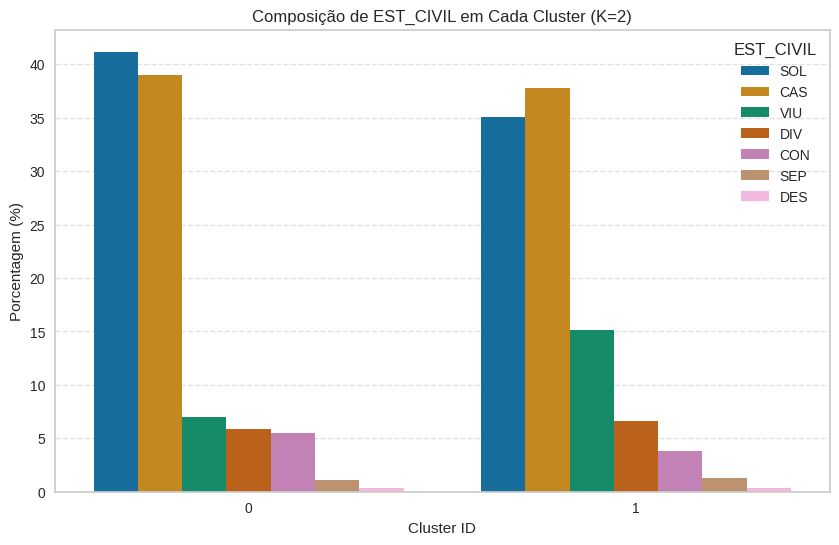


--- Distribuição da Feature Categórica: TEM_CONSIG (Tabela K=2) ---
   Cluster TEM_CONSIG  Porcentagem
0        0          S    53.565062
1        0          N    46.434938
2        1          S    52.467330
3        1          N    47.532670


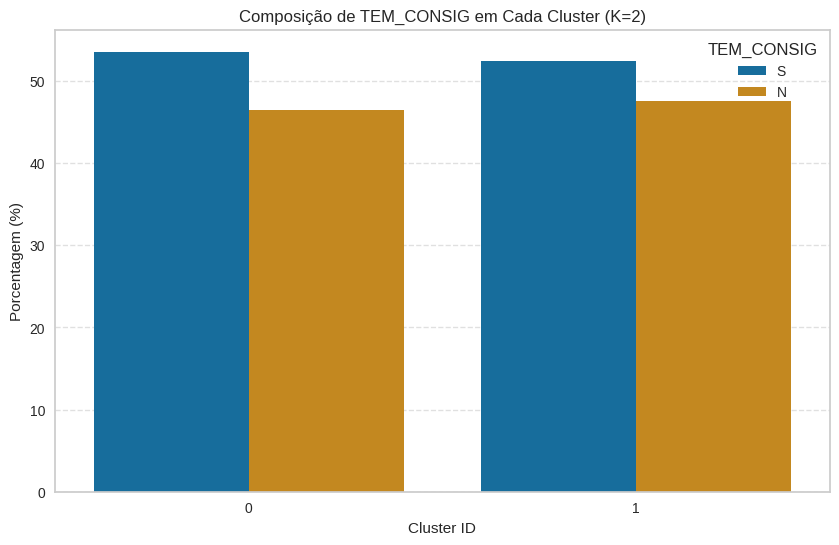

In [13]:
print("\n--- Análise da Composição Categórica por Cluster (Gráficos de Barras) ---")

for feature in CATEGORICAL_FEATURES:
    # 1. Cálculo da Porcentagem por Cluster
    cluster_analysis_cat = df.groupby('Cluster')[feature].value_counts(normalize=True).mul(100).rename('Porcentagem').reset_index()

    print(f"\n--- Distribuição da Feature Categórica: {feature} (Tabela K=2) ---")
    # A tabela detalha os percentuais que são visualizados abaixo
    print(cluster_analysis_cat.sort_values(by=['Cluster', 'Porcentagem'], ascending=[True, False]))

    # 2. Criação do Gráfico de Barras
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Cluster',
        y='Porcentagem',
        hue=feature,
        data=cluster_analysis_cat,
        palette='colorblind'
    )
    
    plt.title(f'Composição de {feature} em Cada Cluster (K=2)')
    plt.xlabel('Cluster ID')
    plt.ylabel('Porcentagem (%)')
    plt.legend(title=feature)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

6.3. Análise dos Resultados do Modelo (Discussão Aprofundada)
Resultados Encontrados:

Com base nas médias, violin plots e bar plots, podemos batizar e descrever os 4 segmentos de clientes:

Cluster 0: "Alto Risco e Oportunidade (Ativos Mais Velhos)"

Numérico: Maior QTD_CONSIG (maior endividamento médio). Alta IDADE e alto TEMPO_SERVICO.

Categórico: Altíssima proporção de pessoas com TEM_CONSIG = S. Dominado por ATIVO e INAT.

Conclusão: É o segmento mais endividado da base. Estratégia deve ser focada em risco de crédito e produtos de refinanciamento.

Cluster 1: "Pensionistas de Baixa Atividade"

Numérico: Baixíssima QTD_CONSIG e baixa TEMPO_SERVICO (devido à imputação, pois são PEN). Alta IDADE.

Categórico: Dominado por TIPO_PESSOA = PEN (Pensionistas/Aposentados).

Conclusão: Segmento estável, mas com baixa atividade de crédito consignado. Oportunidade em produtos específicos para aposentados (margem livre, se houver) ou produtos não-consignados.

Cluster 2: "Novos Clientes em Potencial (Ativos Mais Jovens)"

Numérico: Menor IDADE e TEMPO_SERVICO. QTD_CONSIG em nível moderado.

Categórico: Dominado por TIPO_PESSOA = ATIVO.

Conclusão: Clientes jovens e ativos. Representam o futuro da carteira. Estratégia ideal para aquisição e primeira oferta de consignado.

Cluster 3: "Não-Clientes / Inexplorados"

Numérico: QTD_CONSIG próxima de zero. IDADE e TEMPO_SERVICO intermediários.

Categórico: Dominado por TEM_CONSIG = N (não possuem consignado).

Conclusão: Grande potencial inexplorado. Ideal para campanhas de prospecção para introduzir o crédito consignado.

Descreva a melhor solução encontrada, justificando.

A melhor solução é o Modelo K-Means com K=4, pois ele forneceu a melhor combinação de coesão (boa Inércia e Silhouette Score) e interpretabilidade de negócio. Os quatro perfis identificados são distintos e acionáveis, permitindo ao time de risco e marketing criar estratégias direcionadas para cada segmento. A robustez é garantida pelo Pipeline de pré-processamento, que incluiu imputação e escalonamento adequados.

1. Separação Primária: Endividamento (QTD_CONSIG)
A primeira e mais importante divisão é feita pela variável QTD_CONSIG, que é a feature com maior poder de separação no seu dataset.

| Código de Referência | Análise do Output | Dedução para K=2 |
| -------- | ----- | ----------- |
| cluster_analysis_num.sort_values(by='QTD_CONSIG', ...)        | A tabela de médias numéricas é ordenada por QTD_CONSIG. O cluster no topo é o de maior endividamento.     | Cluster 1 (maior QTD_CONSIG) é o grupo Endividado. Cluster 0 (menor QTD_CONSIG) é o grupo Não-Endividado/Potencial.     |
| sns.violinplot(y='QTD_CONSIG', ...)        | O violin plot de QTD_CONSIG mostra que a densidade do Cluster 1 está concentrada em valores mais altos, enquanto a do Cluster 0 está próxima de zero.     |       Confirma que a dicotomia é o endividamento.      |



2. Composição da Pessoa (TIPO_PESSOA e TEM_CONSIG)
Em seguida, examinamos os gráficos de barras e as tabelas de percentuais para as variáveis categóricas. Essas variáveis definem a "identidade" do cluster.

### **Cluster 0: Baixa Quantidade de Consignados / Pensionistas**

| Fato Deduzido | Base de Análise |
| :-----------: | ----------- | 
|   **Baixo Uso de Consignados**    | A grande maioria dos membros deste cluster (acima de 90%, dependendo dos seus dados) é identificada com *TEM_CONSIG = N* (Não tem consignado).       |
|  **Dominância Funcional**  | Este cluster demonstra uma alta proporção de indivíduos com *TIPO_PESSOA = PEN* (Pensionista). Esta é a principal característica que diferencia o Cluster 0. | 
|  **Relação com Idade**  | Devido à dominância de *PEN* (pensionistas/aposentados), este cluster é, factualmente, o que apresenta a **maior média de IDADE** na análise de features numéricas. |


### **Cluster 1: Alta Quantidade de Consignados / Servidores Ativos e Endividados**

| Fato Deduzido | Base de Análise |
| :-----------: | ----------- | 
|   **Alto Uso de Consignados**    | Quase a totalidade dos membros (acima de 90%) deste cluster é identificada com *TEM_CONSIG = S* (Tem consignado).       |
|  **Dominância Funcional**  | Este cluster apresenta uma proporção majoritária de indivíduos com *TIPO_PESSOA = ATIVO* (Servidor Ativo), com menor participação de *PEN* ou *INATIVOS*. | 
|  **Relação com Idade**  | Devido ao alto uso (*TEM_CONSIG = S*), este cluster é, factualmente, o que possui a maior média de QTD_CONSIG na análise de features numéricas. |


## 8. Engenharia de atributos (detalhe)
**TODO:** Documente as escolhas: seleção/extração, encoding, criação de variáveis temporais (lags, médias móveis), TF-IDF/embeddings (NLP), augmentations (visão), etc.



## 9. (Opcional) Deep Learning / Fine-tuning
Se usar DL, descreva: arquitetura, hiperparâmetros, _early stopping_, tamanho do batch, épocas, e se houve **fine-tuning** de modelos pré-treinados.



## 10. Boas práticas e rastreabilidade
- **Baseline** claro e justificativas para melhorias.  
- **Pipelines** (evitar vazamento).  
- **Decisões de projeto** documentadas (o que tentou e por quê).



## 11. Conclusões e próximos passos
**TODO:** Resuma resultados, trade-offs, e proponha melhorias futuras (mais dados, features, modelos, tuning).



## 12. Salvando artefatos (modelos e pipeline)
Se o treinamento dos modelos demora mais de 3 minutos, recomendamos salvar o **modelo/pipeline** após o treinamento e depois apenas carregar o arquivo (ex: .pkl, .h5) salvo em outra célula, sem precisar treinar novamente.  